### Step 1: Data Generation
First, we generate a synthetic dataset for natural gas prices and consumption. For simplicity, let's assume we have daily data for 10 years.

In [4]:
import pandas as pd
import numpy as np

# Generate synthetic data (same as before)
np.random.seed(42)
date_range = pd.date_range(start='2010-01-01', end='2019-12-31', freq='D')
n = len(date_range)
prices = np.random.normal(loc=3, scale=0.5, size=n)  # Natural gas prices in $/MMBtu
consumption = np.random.normal(loc=70, scale=15, size=n)  # Consumption in Bcf/day
data = pd.DataFrame({'Date': date_range, 'Price': prices, 'Consumption': consumption})
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Create lag features for the model
for lag in range(1, 8):
    data[f'Price_lag_{lag}'] = data['Price'].shift(lag)
    data[f'Consumption_lag_{lag}'] = data['Consumption'].shift(lag)

# Drop rows with missing values
data.dropna(inplace=True)

# Train-test split
train_data = data[:'2018']
test_data = data['2019':]

X_train = train_data.drop(columns=['Price'])
y_train = train_data['Price']
X_test = test_data.drop(columns=['Price'])
y_test = test_data['Price']


### Step 2: Model Building
We'll use a Seasonal ARIMA (SARIMA) model to forecast natural gas prices. SARIMA models are suitable for time series data with seasonality.

#### 2.1 Data Preprocessing
Before modeling, we need to ensure our data is stationary and split it into training and testing sets.

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Evaluate the model
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

print(f'Random Forest MAE: {rf_mae}')
print(f'Random Forest RMSE: {rf_rmse}')


Random Forest MAE: 0.42461603053083735
Random Forest RMSE: 0.5287624640792543


#### 2.2 Model Training

In [8]:
import xgboost as xgb

# Train the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the model
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))

print(f'XGBoost MAE: {xgb_mae}')
print(f'XGBoost RMSE: {xgb_rmse}')


XGBoost MAE: 0.44675317575982565
XGBoost RMSE: 0.5604654301119719


In [9]:
print("Random Forest Performance:")
print(f'MAE: {rf_mae}')
print(f'RMSE: {rf_rmse}')

print("\nXGBoost Performance:")
print(f'MAE: {xgb_mae}')
print(f'RMSE: {xgb_rmse}')

if xgb_rmse < rf_rmse:
    print("\nXGBoost performed better than Random Forest.")
else:
    print("\nRandom Forest performed better than XGBoost.")


Random Forest Performance:
MAE: 0.42461603053083735
RMSE: 0.5287624640792543

XGBoost Performance:
MAE: 0.44675317575982565
RMSE: 0.5604654301119719

Random Forest performed better than XGBoost.


In [16]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Train the model with the best parameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Make predictions
best_rf_predictions = best_rf_model.predict(X_test)

# Evaluate the model
best_rf_mae = mean_absolute_error(y_test, best_rf_predictions)
best_rf_rmse = np.sqrt(mean_squared_error(y_test, best_rf_predictions))

print(f'Optimized Random Forest MAE: {best_rf_mae}')
print(f'Optimized Random Forest RMSE: {best_rf_rmse}')


Fitting 3 folds for each of 648 candidates, totalling 1944 fits


C:\Users\JusticePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
402 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JusticePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JusticePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\JusticePC\AppData\Local\Programs\Python\Python311\Lib\site-pack

Best parameters found:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Optimized Random Forest MAE: 0.42430574717648656
Optimized Random Forest RMSE: 0.526044871561062


In [17]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate RMSE for each fold
cv_rmse_scores = np.sqrt(-cv_scores)

print("Cross-validated RMSE scores: ", cv_rmse_scores)
print("Mean cross-validated RMSE: ", cv_rmse_scores.mean())
print("Standard deviation of cross-validated RMSE: ", cv_rmse_scores.std())


Cross-validated RMSE scores:  [0.4928865  0.49692892 0.50099251 0.48735091 0.50555609]
Mean cross-validated RMSE:  0.4967429848329232
Standard deviation of cross-validated RMSE:  0.006306304784098574


In [18]:
# Make predictions on the test set
final_predictions = best_rf_model.predict(X_test)

# Evaluate the model
final_mae = mean_absolute_error(y_test, final_predictions)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))

print(f'Final Model MAE: {final_mae}')
print(f'Final Model RMSE: {final_rmse}')


Final Model MAE: 0.42430574717648656
Final Model RMSE: 0.526044871561062


In [19]:
import joblib

# Save the model to a file
joblib.dump(best_rf_model, 'random_forest_model.pkl')


['random_forest_model.pkl']

In [20]:
# Load the model from a file
loaded_model = joblib.load('random_forest_model.pkl')

# Make predictions with the loaded model
loaded_predictions = loaded_model.predict(X_test)


In [21]:
print(loaded_predictions)

[3.03555886 3.04808245 2.96196856 3.03872681 2.99905952 3.03676513
 3.05015125 2.92307801 3.03037903 2.99418529 3.0676705  3.07562012
 3.06630322 2.99728611 3.00052962 3.03488443 3.03274015 3.01300411
 3.01616704 2.94372978 3.00213451 2.99971179 2.98545883 3.05022786
 3.03002754 3.04770176 2.99235656 3.08500904 3.01718489 3.02482787
 3.07858608 3.01901123 2.97441989 2.97234887 3.00208991 2.98744653
 3.08938388 3.00040438 3.02990885 3.02991067 2.89642263 3.03593086
 3.03176728 3.09611674 3.02185773 3.03298647 3.03495819 2.96024039
 3.02781944 2.98881476 3.03086016 2.99430654 3.03454259 3.01146805
 3.02471244 2.96873221 3.01563315 3.02069352 3.10606075 2.98015422
 2.97823126 3.03737725 3.02167036 3.02932376 3.02681447 2.99627962
 3.02915867 3.03193285 2.95756834 2.95313723 2.97726342 2.99404491
 2.95905276 3.01538303 3.02543194 3.03655947 3.06236886 3.01442159
 3.05499013 2.98518529 2.98260667 3.01125118 3.06421545 3.05748412
 3.0155014  3.07179912 2.97214715 3.02496265 2.91736044 3.0248

In [22]:
# Assuming y_test contains the actual prices
predictions_vs_actual = pd.DataFrame({
    'Date': X_test.index,  # Dates from the test set
    'Actual': y_test,      # Actual prices
    'Predicted': loaded_predictions  # Predicted prices
})

# Print the first few rows to compare
print(predictions_vs_actual.head())


                 Date    Actual  Predicted
Date                                      
2019-01-01 2019-01-01  2.894167   3.035559
2019-01-02 2019-01-02  2.686133   3.048082
2019-01-03 2019-01-03  2.855981   2.961969
2019-01-04 2019-01-04  3.709266   3.038727
2019-01-05 2019-01-05  1.756096   2.999060


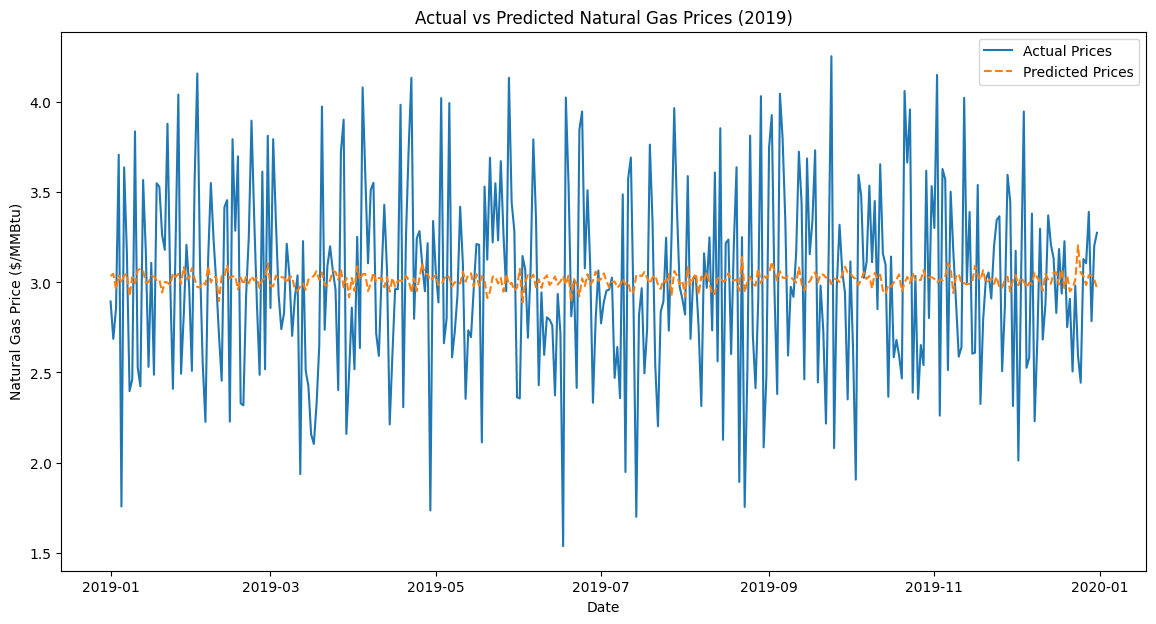

In [23]:
import matplotlib.pyplot as plt

# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(predictions_vs_actual['Date'], predictions_vs_actual['Actual'], label='Actual Prices')
plt.plot(predictions_vs_actual['Date'], predictions_vs_actual['Predicted'], label='Predicted Prices', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Natural Gas Price ($/MMBtu)')
plt.title('Actual vs Predicted Natural Gas Prices (2019)')
plt.legend()
plt.show()
